In [1]:
import tensorflow as tf
from keras.layers import Input, Dense, Reshape, Dropout, Activation
from keras.layers import LSTM, Bidirectional, BatchNormalization, ZeroPadding2D
from keras.models import Sequential, Model
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.utils import np_utils
import pretty_midi
import pickle

Using TensorFlow backend.


In [2]:
import re
import glob

In [5]:
import numpy as np
import pandas as pd

import scipy.stats as stats
import matplotlib.pyplot as plot
import sklearn
import seaborn as sns
import pickle

import pandas_profiling

#Path for the groove dataset
MIDI_PATH = "/home/mark/repos/Springboard/data/"
DATA_PATH = "/home/mark/repos/Springboard/data/info.csv"

groove_df = pd.read_csv(DATA_PATH)
#groove_df

In [6]:
groove_df = groove_df[groove_df.beat_type != 'fill']
short = groove_df[groove_df.duration <=30]

styles = groove_df['style'].value_counts()

#Method 1: Add the multi-style to the first substyle.
for s in styles.index:
    if '/' in s:
        print(s)
        style_a,style_b = s.split('/')
        print(s.split('/'))
        if style_a in styles.index:
            split_style = groove_df.query('style=="'+s+'"')
            groove_df = groove_df.replace({'style':{s:style_a}})
        if style_b in styles.index:
            split_style = groove_df.query('style=="'+s+'"')
            groove_df = groove_df.replace({'style':{s:style_b}})

styles = groove_df['style'].value_counts()


style_durations = pd.DataFrame(columns=['style','max','min','sum'])
for s in styles.index:
    style_df = groove_df.query('style=="'+s+'"')
    style_durations = style_durations.append({'style': s, 'max': style_df['duration'].max(), 
                                             'min': style_df['duration'].min(), 'sum': int(style_df['duration'].sum())},
                                             ignore_index=True)

jazz/swing
['jazz', 'swing']
jazz
neworleans/funk
['neworleans', 'funk']
funk
latin/brazilian-samba
['latin', 'brazilian-samba']
latin
blues/shuffle
['blues', 'shuffle']
hiphop/groove6
['hiphop', 'groove6']
hiphop
jazz/fusion
['jazz', 'fusion']
jazz
soul/groove9
['soul', 'groove9']
soul
funk/groove5
['funk', 'groove5']
funk
soul/groove3
['soul', 'groove3']
soul
latin/brazilian
['latin', 'brazilian']
latin
funk/groove2
['funk', 'groove2']
funk
pop/groove7
['pop', 'groove7']
pop
soul/groove4
['soul', 'groove4']
soul
soul/motown
['soul', 'motown']
soul
rock/groove8
['rock', 'groove8']
rock
funk/groove1
['funk', 'groove1']
funk
soul/groove10
['soul', 'groove10']
soul
neworleans/secondline
['neworleans', 'secondline']
latin/brazilian-songo
['latin', 'brazilian-songo']
latin
latin/brazilian-baiao
['latin', 'brazilian-baiao']
latin
latin/brazilian-ijexa
['latin', 'brazilian-ijexa']
latin
pop/soft
['pop', 'soft']
pop
latin/brazilian-sambareggae
['latin', 'brazilian-sambareggae']
latin
dance/di

In [ ]:
pandas_profiling.ProfileReport(groove_df)

In [7]:
styles_removed = style_durations[style_durations['sum'] < 100]

In [8]:
#Generates MIDI list for each genre
genre_midi_list = {}
for s in styles.index:
    style_df = groove_df.query('style=="'+s+'"')
    genre_midi_list[s] = style_df.midi_filename.tolist()


In [21]:
#Test with one genre
r_list = genre_midi_list['rock']

In [10]:

n_x = 79
max_T_x = 1000
sequence_length = 20
T_y_generated = 200

In [11]:
def get_notes(midi_list):
    notes = []
    for file in midi_list:
        midi = pretty_midi.PrettyMIDI(MIDI_PATH + file)
        for instrument in midi.instruments:
            if instrument.is_drum:
                for note in instrument.notes:
                    if int(note.pitch) >= 35 and int(note.pitch) <= 81:
                        notes.append((note.pitch))
    return notes

In [12]:
def prepare_sequences(notes, n_vocab):
    sequence_length = 100
    print("\n**Preparing sequences for training**")
    pitchnames = sorted(set(i for i in notes)) # list of unique chords and notes
    #n_vocab = len(pitchnames)
    print("Pitchnames (unique notes/chords from 'notes') at length {}: {}".format(len(pitchnames),pitchnames))
    # enumerate pitchnames into dictionary embedding
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
    print("Note to integer embedding created at length {}".format(len(note_to_int)))

    network_input = []
    network_output = []

    # i equals total notes less declared sequence length of LSTM (ie 5000 - 100)
    # sequence input for each i is list of notes i to end of sequence length (ie 0-100 for i = 0)
    # sequence output for each i is single note at i + sequence length (ie 100 for i = 0)
    for i in range(0, len(notes) - sequence_length,1):
        sequence_in = notes[i:i + sequence_length] # 100
        sequence_out = notes[i + sequence_length] # 1

        # enumerate notes and chord sequences with note_to_int enumerated encoding
        # network input/output is a list of encoded notes and chords based on note_to_int encoding
        # if 100 unique notes/chords, the encoding will be between 0-100
        input_add = [note_to_int[char] for char in sequence_in]
        network_input.append(input_add) # sequence length
        output_add = note_to_int[sequence_out]
        network_output.append(output_add) # single note

    print("Network input and output created with (pre-transform) lengths {} and {}".format(len(network_input),len(network_output)))
    # print("Network input and output first list items: {} and {}".format(network_input[0],network_output[0]))
    # print("Network input list item length: {}".format(len(network_input[0])))
    n_patterns = len(network_input) # notes less sequence length
    print("Lengths. N Vocab: {} N Patterns: {} Pitchnames: {}".format(n_vocab,n_patterns, len(pitchnames)))
    print("\n**Reshaping for training**")

    # convert network input/output from lists to numpy arrays
    # reshape input to (notes less sequence length, sequence length)
    # reshape output to (notes less sequence length, unique notes/chords)
    network_input_r = np.reshape(network_input, (n_patterns, sequence_length, 1))
    
    #Normalize input
    network_input_r = (network_input_r - (float(n_vocab) / 2)) / (float(n_vocab) / 2)
    
    network_output_r = np_utils.to_categorical(network_output)

    print("Reshaping network input to (notes - sequence length, sequence length) {}".format(network_input_r.shape))
    print("Reshaping network output to (notes - sequence length, unique notes) {}".format(network_output_r.shape))
    return network_input_r, network_output_r, n_patterns, n_vocab, pitchnames

In [13]:

notes = get_notes(r_list)
n_vocab = len(set(notes))
print (set(notes))

{36, 37, 38, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 57, 58, 59}


In [14]:
network_input, network_output, n_patterns, n_vocab, pitchnames = prepare_sequences(notes, n_vocab)


**Preparing sequences for training**
Pitchnames (unique notes/chords from 'notes') at length 20: [36, 37, 38, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 57, 58, 59]
Note to integer embedding created at length 20
Network input and output created with (pre-transform) lengths 303863 and 303863
Lengths. N Vocab: 20 N Patterns: 303863 Pitchnames: 20

**Reshaping for training**
Reshaping network input to (notes - sequence length, sequence length) (303863, 100, 1)
Reshaping network output to (notes - sequence length, unique notes) (303863, 20)


{55: 2136, 51: 33149, 36: 67336, 44: 37565, 38: 77168, 40: 16797, 37: 8934, 52: 967, 43: 9063, 53: 5053, 42: 26645, 48: 8219, 46: 2166, 59: 1868, 50: 1355, 45: 2843, 47: 1133, 58: 906, 49: 377, 57: 283}


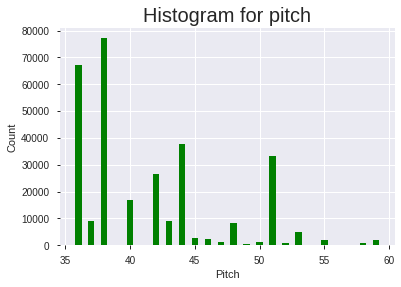

In [15]:
#importing library
from collections import Counter
freq = dict(Counter(notes))
print (freq)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#set figure
f, ax = plt.subplots(1,1)

#plt.figure(figsize=(15,5))
plt.bar(freq.keys(), freq.values(), width=.5, color='g')
#set title & axis titles
ax.set_title('Histogram for pitch', fontsize=20)
ax.set_xlabel('Pitch')
ax.set_ylabel('Count')
plt.show()

In [16]:
class GAN():
    def __init__(self, rows):
        self.seq_length = rows
        self.seq_shape = (self.seq_length, 1)
        self.latent_dim = 1000
        self.disc_loss = []
        self.gen_loss =[]
        
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates note sequence
        
        z = Input(shape=(self.latent_dim,))
        generated_seq = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(generated_seq)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        

    def build_discriminator(self):

        model = Sequential()
        model.add(LSTM(512, input_shape=self.seq_shape, return_sequences=True))
        model.add(Bidirectional(LSTM(512)))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.3))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.3))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        seq = Input(shape=self.seq_shape)
        validity = model(seq)

        return Model(seq, validity)
      
    def build_generator(self):

        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.3))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.3))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.3))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.seq_shape), activation='tanh'))
        model.add(Reshape(self.seq_shape))
        model.add(Dropout(0.2))
        model.summary()
        
        noise = Input(shape=(self.latent_dim,))
        seq = model(noise)

        return Model(noise, seq)

    def train(self, genre_dataset, epochs, batch_size=128, sample_interval=25):

        # Load and convert the data
        notes = get_notes(genre_dataset)
        n_vocab = len(set(notes))
        X_train, y_train, n_patterns, n_vocab, pitchnames = prepare_sequences(notes, n_vocab)

        # Adversarial ground truths
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        # Training the model
        for epoch in range(epochs):

            # Training the discriminator
            # Select a random batch of note sequences
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_seqs = X_train[idx]

            #noise = np.random.choice(range(484), (batch_size, self.latent_dim))
            #noise = (noise-242)/242
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            
            # Generate a batch of new note sequences
            
            gen_seqs = self.generator.predict(noise)
            

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(real_seqs, real)
            d_loss_fake = self.discriminator.train_on_batch(gen_seqs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            #  Training the Generator
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            #valid_y = np.array([1] * batch_size)
            
            # Train the generator (to have the discriminator label samples as real)
            g_loss = self.combined.train_on_batch(noise, real)

            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            # Print the progress and save into loss lists
            #if epoch % sample_interval == 0:
                #print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                #self.disc_loss.append(d_loss[0])
                #self.gen_loss.append(g_loss)
        #self.generate(notes)
        #self.plot_loss()
        
    def plot_loss(self):
        plt.plot(self.disc_loss, c='red')
        plt.plot(self.gen_loss, c='blue')
        plt.title("GAN Loss per Epoch")
        plt.legend(['Discriminator', 'Generator'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig('GAN_Loss_per_Epoch_final.png', transparent=True)
        plt.close()

In [17]:
gan = GAN(rows=100)
gan.train(genre_dataset=r_list, epochs=1000, batch_size=32, sample_interval=1)

W0411 11:15:10.208863 140715302537024 module_wrapper.py:139] From /home/mark/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0411 11:15:10.211017 140715302537024 module_wrapper.py:139] From /home/mark/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0411 11:15:10.214578 140715302537024 module_wrapper.py:139] From /home/mark/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 512)          1052672   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1024)              4198400   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total para

W0411 11:15:13.288564 140715302537024 module_wrapper.py:139] From /home/mark/.local/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0411 11:15:13.297116 140715302537024 module_wrapper.py:139] From /home/mark/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0411 11:15:13.304457 140715302537024 deprecation.py:323] From /home/mark/.conda/envs/Springboard/lib/python3.6/site-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0411 11:15:13.533144 140715302537024 module_wrapper.py:139] From /home/mark/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               256256    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              525312    
__________

W0411 11:16:35.984421 140715302537024 module_wrapper.py:139] From /home/mark/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0411 11:16:35.986739 140715302537024 module_wrapper.py:139] From /home/mark/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0411 11:16:35.989107 140715302537024 module_wrapper.py:139] From /home/mark/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



Reshaping network input to (notes - sequence length, sequence length) (303863, 100, 1)
Reshaping network output to (notes - sequence length, unique notes) (303863, 20)


W0411 11:16:36.333820 140715302537024 module_wrapper.py:139] From /home/mark/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0411 11:16:36.336492 140715302537024 module_wrapper.py:139] From /home/mark/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.

W0411 11:16:37.153687 140715302537024 module_wrapper.py:139] From /home/mark/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.

/home/mark/.local/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  

0 [D loss: 0.697647, acc.: 45.31%] [G loss: 0.688935]


/home/mark/.local/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.669844, acc.: 75.00%] [G loss: 0.684293]
2 [D loss: 0.639244, acc.: 70.31%] [G loss: 0.686888]
3 [D loss: 0.602099, acc.: 70.31%] [G loss: 0.702859]
4 [D loss: 0.520647, acc.: 78.12%] [G loss: 0.722041]
5 [D loss: 0.370057, acc.: 81.25%] [G loss: 1.197731]
6 [D loss: 0.576578, acc.: 81.25%] [G loss: 1.118193]
7 [D loss: 0.313859, acc.: 95.31%] [G loss: 1.045206]
8 [D loss: 0.342583, acc.: 96.88%] [G loss: 1.488775]
9 [D loss: 0.226510, acc.: 93.75%] [G loss: 6.804848]
10 [D loss: 0.307913, acc.: 89.06%] [G loss: 2.271979]
11 [D loss: 0.106092, acc.: 98.44%] [G loss: 3.214393]
12 [D loss: 0.093501, acc.: 95.31%] [G loss: 4.017778]
13 [D loss: 0.052274, acc.: 98.44%] [G loss: 5.880082]
14 [D loss: 0.095330, acc.: 95.31%] [G loss: 9.591565]
15 [D loss: 0.159532, acc.: 95.31%] [G loss: 7.888050]
16 [D loss: 0.153248, acc.: 92.19%] [G loss: 5.069016]
17 [D loss: 0.074165, acc.: 96.88%] [G loss: 8.881224]
18 [D loss: 0.123307, acc.: 95.31%] [G loss: 7.692741]
19 [D loss: 0.15499

150 [D loss: 0.331121, acc.: 84.38%] [G loss: 2.414769]
151 [D loss: 0.383035, acc.: 81.25%] [G loss: 2.737596]
152 [D loss: 0.427161, acc.: 76.56%] [G loss: 2.017244]
153 [D loss: 0.529659, acc.: 81.25%] [G loss: 1.649459]
154 [D loss: 0.373550, acc.: 87.50%] [G loss: 2.429234]
155 [D loss: 0.216044, acc.: 90.62%] [G loss: 5.915756]
156 [D loss: 0.315600, acc.: 85.94%] [G loss: 1.872173]
157 [D loss: 0.368196, acc.: 82.81%] [G loss: 1.920852]
158 [D loss: 0.355414, acc.: 84.38%] [G loss: 2.247403]
159 [D loss: 0.479162, acc.: 78.12%] [G loss: 2.129358]
160 [D loss: 0.334282, acc.: 81.25%] [G loss: 2.419474]
161 [D loss: 0.317132, acc.: 81.25%] [G loss: 4.044561]
162 [D loss: 0.286362, acc.: 82.81%] [G loss: 4.278559]
163 [D loss: 0.427259, acc.: 81.25%] [G loss: 1.997857]
164 [D loss: 0.258224, acc.: 92.19%] [G loss: 2.497412]
165 [D loss: 0.317967, acc.: 81.25%] [G loss: 2.411947]
166 [D loss: 0.274996, acc.: 85.94%] [G loss: 3.061620]
167 [D loss: 0.458324, acc.: 79.69%] [G loss: 1.

297 [D loss: 0.587810, acc.: 68.75%] [G loss: 1.066630]
298 [D loss: 0.542312, acc.: 73.44%] [G loss: 2.030416]
299 [D loss: 0.493800, acc.: 76.56%] [G loss: 3.185400]
300 [D loss: 0.578702, acc.: 70.31%] [G loss: 4.942839]
301 [D loss: 1.267360, acc.: 53.12%] [G loss: 0.886079]
302 [D loss: 0.613269, acc.: 75.00%] [G loss: 0.880686]
303 [D loss: 0.592830, acc.: 75.00%] [G loss: 0.913561]
304 [D loss: 0.616933, acc.: 68.75%] [G loss: 1.047657]
305 [D loss: 0.587418, acc.: 67.19%] [G loss: 1.097372]
306 [D loss: 0.624438, acc.: 67.19%] [G loss: 1.254512]
307 [D loss: 0.566653, acc.: 71.88%] [G loss: 1.256783]
308 [D loss: 0.599887, acc.: 70.31%] [G loss: 1.402540]
309 [D loss: 0.595987, acc.: 67.19%] [G loss: 1.464673]
310 [D loss: 0.648620, acc.: 60.94%] [G loss: 1.372750]
311 [D loss: 0.574776, acc.: 67.19%] [G loss: 1.335840]
312 [D loss: 0.613598, acc.: 65.62%] [G loss: 1.517033]
313 [D loss: 0.549271, acc.: 73.44%] [G loss: 1.472196]
314 [D loss: 0.586981, acc.: 67.19%] [G loss: 1.

444 [D loss: 0.625899, acc.: 56.25%] [G loss: 0.896886]
445 [D loss: 0.650359, acc.: 62.50%] [G loss: 1.196354]
446 [D loss: 0.622614, acc.: 64.06%] [G loss: 1.364190]
447 [D loss: 0.679702, acc.: 53.12%] [G loss: 1.092845]
448 [D loss: 0.622155, acc.: 62.50%] [G loss: 1.168899]
449 [D loss: 0.647242, acc.: 60.94%] [G loss: 1.184201]
450 [D loss: 0.658575, acc.: 60.94%] [G loss: 1.116176]
451 [D loss: 0.612692, acc.: 60.94%] [G loss: 1.175390]
452 [D loss: 0.621543, acc.: 65.62%] [G loss: 1.565444]
453 [D loss: 0.627883, acc.: 64.06%] [G loss: 1.719118]
454 [D loss: 0.693587, acc.: 65.62%] [G loss: 1.781160]
455 [D loss: 0.654352, acc.: 67.19%] [G loss: 1.176485]
456 [D loss: 0.623841, acc.: 59.38%] [G loss: 1.463847]
457 [D loss: 0.622097, acc.: 70.31%] [G loss: 0.856058]
458 [D loss: 0.629973, acc.: 68.75%] [G loss: 0.832319]
459 [D loss: 0.612794, acc.: 67.19%] [G loss: 0.849267]
460 [D loss: 0.637054, acc.: 62.50%] [G loss: 0.919051]
461 [D loss: 0.604930, acc.: 71.88%] [G loss: 0.

591 [D loss: 0.677461, acc.: 59.38%] [G loss: 1.124156]
592 [D loss: 0.686002, acc.: 53.12%] [G loss: 1.114775]
593 [D loss: 0.686075, acc.: 56.25%] [G loss: 1.067005]
594 [D loss: 0.644937, acc.: 65.62%] [G loss: 1.106873]
595 [D loss: 0.649610, acc.: 59.38%] [G loss: 1.471030]
596 [D loss: 0.598183, acc.: 68.75%] [G loss: 1.812151]
597 [D loss: 0.841888, acc.: 57.81%] [G loss: 0.948669]
598 [D loss: 0.659562, acc.: 64.06%] [G loss: 0.945427]
599 [D loss: 0.626052, acc.: 70.31%] [G loss: 0.992432]
600 [D loss: 0.606044, acc.: 78.12%] [G loss: 1.104591]
601 [D loss: 0.637479, acc.: 64.06%] [G loss: 1.176699]
602 [D loss: 0.621053, acc.: 64.06%] [G loss: 1.308265]
603 [D loss: 0.534505, acc.: 75.00%] [G loss: 1.325810]
604 [D loss: 0.644160, acc.: 62.50%] [G loss: 1.204610]
605 [D loss: 0.605093, acc.: 68.75%] [G loss: 1.329285]
606 [D loss: 0.539110, acc.: 70.31%] [G loss: 1.577962]
607 [D loss: 0.712817, acc.: 59.38%] [G loss: 1.233343]
608 [D loss: 0.548163, acc.: 79.69%] [G loss: 1.

738 [D loss: 0.404375, acc.: 85.94%] [G loss: 1.491548]
739 [D loss: 0.550938, acc.: 73.44%] [G loss: 1.321597]
740 [D loss: 0.459841, acc.: 79.69%] [G loss: 1.434003]
741 [D loss: 0.363920, acc.: 84.38%] [G loss: 1.633643]
742 [D loss: 0.617954, acc.: 67.19%] [G loss: 1.530069]
743 [D loss: 0.573350, acc.: 70.31%] [G loss: 1.405737]
744 [D loss: 0.598215, acc.: 64.06%] [G loss: 1.278362]
745 [D loss: 0.483584, acc.: 79.69%] [G loss: 1.263528]
746 [D loss: 0.552810, acc.: 75.00%] [G loss: 1.283184]
747 [D loss: 0.570038, acc.: 67.19%] [G loss: 1.248399]
748 [D loss: 0.517658, acc.: 75.00%] [G loss: 1.233825]
749 [D loss: 0.613380, acc.: 68.75%] [G loss: 1.255625]
750 [D loss: 0.605952, acc.: 67.19%] [G loss: 1.149690]
751 [D loss: 0.730547, acc.: 56.25%] [G loss: 1.101903]
752 [D loss: 0.580534, acc.: 68.75%] [G loss: 1.182458]
753 [D loss: 0.569519, acc.: 75.00%] [G loss: 1.241552]
754 [D loss: 0.556611, acc.: 71.88%] [G loss: 1.249733]
755 [D loss: 0.464693, acc.: 79.69%] [G loss: 1.

885 [D loss: 0.388307, acc.: 84.38%] [G loss: 1.786777]
886 [D loss: 0.537724, acc.: 75.00%] [G loss: 1.658026]
887 [D loss: 0.437240, acc.: 78.12%] [G loss: 1.725830]
888 [D loss: 0.542592, acc.: 76.56%] [G loss: 1.640850]
889 [D loss: 0.619803, acc.: 62.50%] [G loss: 1.469436]
890 [D loss: 0.480707, acc.: 79.69%] [G loss: 1.429758]
891 [D loss: 0.400478, acc.: 85.94%] [G loss: 1.711182]
892 [D loss: 0.470243, acc.: 78.12%] [G loss: 1.733736]
893 [D loss: 0.551733, acc.: 70.31%] [G loss: 1.568646]
894 [D loss: 0.496389, acc.: 78.12%] [G loss: 1.497298]
895 [D loss: 0.496450, acc.: 73.44%] [G loss: 1.513441]
896 [D loss: 0.377612, acc.: 84.38%] [G loss: 1.654515]
897 [D loss: 0.794598, acc.: 65.62%] [G loss: 1.415882]
898 [D loss: 0.442989, acc.: 78.12%] [G loss: 1.358044]
899 [D loss: 0.525957, acc.: 73.44%] [G loss: 1.350713]
900 [D loss: 0.502764, acc.: 71.88%] [G loss: 1.411953]
901 [D loss: 0.509929, acc.: 75.00%] [G loss: 1.439884]
902 [D loss: 0.562738, acc.: 68.75%] [G loss: 1.

In [18]:
def generate(gan, input_notes):
        # Get pitch names and store in a dictionary
        notes = input_notes
        
        pitchnames = sorted(set(item for item in notes))
        int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
        #print (int_to_note)
        # Use random noise to generate sequences
        noise = np.random.normal(0, 1, (1, gan.latent_dim))
        length = len(pitchnames) / 2
        predictions = gan.generator.predict(noise)
        #print(predictions)
        pred_notes = [x*length+length for x in predictions[0]]
        pred_notes = [int_to_note[int(x)] for x in pred_notes]
        notess = []
        #print(len(pred_notes))
        for x in pred_notes:
            notess.append(int(x))
        return notess
predictions = generate(gan, notes)
print(predictions)

[58, 53, 46, 49, 49, 50, 44, 57, 47, 36, 59, 49, 51, 40, 59, 40, 38, 52, 48, 38, 52, 52, 48, 42, 52, 52, 52, 48, 55, 43, 38, 51, 55, 44, 43, 42, 50, 59, 46, 53, 47, 37, 59, 40, 45, 50, 57, 48, 40, 51, 38, 50, 49, 43, 36, 59, 37, 37, 59, 45, 51, 37, 49, 59, 36, 49, 53, 37, 59, 36, 55, 40, 37, 42, 59, 59, 51, 58, 36, 37, 36, 59, 58, 38, 42, 47, 36, 59, 37, 57, 57, 51, 36, 36, 38, 36, 55, 47, 47, 38]


In [19]:
def create_midi(notes):
    new_midi_data = pretty_midi.PrettyMIDI()
    drum = pretty_midi.Instrument(program=0, is_drum=True, name="Midi Drums" )
    time = 0
    step = 0.25
    len_notes = len(notes)
    vec_arr = np.random.uniform(50,125,len_notes)
    delta_arr = np.random.uniform(0.2,0.5,len_notes)
    for i,note_number in enumerate(notes):
        myNote = pretty_midi.Note(velocity=int(vec_arr[i]), pitch=int(note_number), start=time, end=time+delta_arr[i])
        drum.notes.append(myNote)
        time += step
    new_midi_data.instruments.append(drum)
    return new_midi_data

new_midi_data = create_midi(predictions)
new_midi_data.write('/home/mark/repos/Springboard/result/final_2.mid')

In [ ]:
#Tested with full list of drum tracks
full_list = groove_df.midi_filename.tolist()
gan = GAN(rows=100)
gan.train(genre_dataset=full_list, epochs=1000, batch_size=32, sample_interval=1)

In [ ]:
predictions = generate(gan, notes)
print(predictions)

In [ ]:
new_midi_data = create_midi(predictions)
new_midi_data.write('/home/mark/repos/Springboard/result/final_2.mid')